# Itroduction
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

**What?** Hierarchical Partial Pooling

</font>
</div>

# Import modules
<hr style = "border:2px solid black" ></hr>

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

# Problem statement
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- Suppose you are tasked with estimating baseball batting skills for several players. One such performance metric is batting average. 

- Since players play a different number of games and bat in different positions in the order, each player has a different number of at-bats. 

- However, you want to estimate the skill of all players, including those with a relatively small number of batting opportunities.

- We will use PyMC3 to estimate the batting average for each player. Having estimated the averages across all players in the datasets, we can use this information to inform an estimate of an additional player, for which there is little data (i.e. 4 at-bats). **The fact that he has been to bat only 4 times, and never hit the ball, does it mean he's a bad player? Not really! This notebook explains how this question can be addressed.**

</font>
</div>

# What is hierarchical partial pooling?
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- There are at least 4 options we can use to model this type of problem.

- **Option #1**: Independently compute batting average for each player (**no pooling**). This is unrealistic because professional baseball players are similar in many ways, so their averages aren’t entirely independent either.

- **Option #2** Compute an overall average, under the assumption that everyone has the same underlying average (**complete pooling**). This is unrealistic because all players aren’t equally skilled hitters.

- **Option #3** It may be possible to **cluster** groups of “similar” players, and estimate group averages.

- **Option #4** hierarchical modeling approach is a natural way of sharing information that *does not involve* identifying ad hoc clusters. The idea of hierarchical partial pooling is to model the global performance, and use that estimate to parameterize a population of players that accounts for differences among the players’ performances. This tradeoff between global and individual performance will be automatically tuned by the model. 

</font>
</div>

# Import dataset
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- We will use the [baseball data for 18 players from Efron and Morris (1975).](http://www.swarthmore.edu/NatSci/peverso1/Sports%20Data/JamesSteinData/Efron-Morris%20Baseball/EfronMorrisBB.txt)

</font>
</div>

In [3]:
data = pd.read_csv(pm.get_data("efron-morris-75-data.tsv"), sep="\t")
at_bats, hits = data[["At-Bats", "Hits"]].to_numpy().T

# Developing a generative model
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-info">
<font color=black>

- We will assume that there exists a hidden factor (phi) related to the expected performance for all players (not limited to our 18). Since the population mean is an unknown value between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. Hence, a natural choice for a prior distribution is the uniform distribution.

- Next, we introduce a hyperparameter kappa to account for the variance in the population batting averages, for which we will use a bounded Pareto distribution. This will ensure that the estimated value falls within reasonable bounds. These hyperparameters will be, in turn, used to parameterize a beta distribution, which is ideal for modeling quantities on the unit interval. The beta distribution is typically parameterized via a scale and shape parameter.

- The final step is to specify a sampling distribution for the data (hit or miss) for every player, using a Binomial distribution. This is where the data are brought to bear on the model.

- We could use pm.Pareto('kappa', m=1.5), to define our prior on kappa, but the Pareto distribution has very long tails. Exploring these properly is difficult for the sampler, so we use an equivalent but faster parametrization using the exponential distribution. We use the fact that the log of a Pareto distributed random variable follows an exponential distribution.

</font>
</div>

In [4]:
N = len(hits)

with pm.Model() as baseball_model:

    phi = pm.Uniform("phi", lower=0.0, upper=1.0)

    kappa_log = pm.Exponential("kappa_log", lam=1.5)
    kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

    thetas = pm.Beta("thetas", alpha=phi * kappa,
                     beta=(1.0 - phi) * kappa, shape=N)
    y = pm.Binomial("y", n=at_bats, p=thetas, observed=hits)

<div class="alert alert-info">
<font color=black>

- Recall our original question was with regard to the true batting average for a player with only 4 at bats and no hits. 

- We can add this as an additional variable in the model 

</font>
</div>

In [5]:
with baseball_model:

    theta_new = pm.Beta("theta_new", alpha=phi * kappa,
                        beta=(1.0 - phi) * kappa)
    y_new = pm.Binomial("y_new", n=4, p=theta_new, observed=0)

In [6]:
# Fitting the model
with baseball_model:
    trace = pm.sample(2000, tune=2000, chains=2,
                      target_accept=0.95, return_inferencedata=True)

    # check convergence diagnostics
    assert all(az.rhat(trace) < 1.03)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [theta_new, thetas, kappa_log, phi]


Sampling 2 chains for 2_000 tune and 2_000 draw iterations (4_000 + 4_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.


array([[<AxesSubplot:title={'center':'phi'}>,
        <AxesSubplot:title={'center':'phi'}>],
       [<AxesSubplot:title={'center':'kappa'}>,
        <AxesSubplot:title={'center':'kappa'}>]], dtype=object)

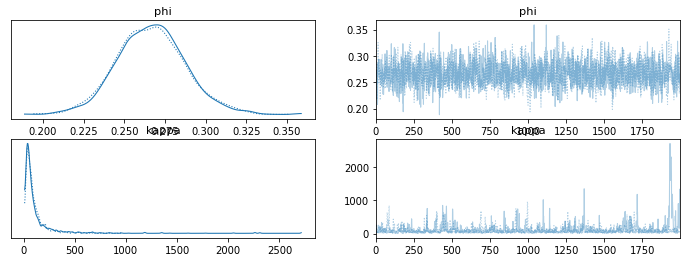

In [7]:
# Plotting the population hyperparameters:
az.plot_trace(trace, var_names=["phi", "kappa"])

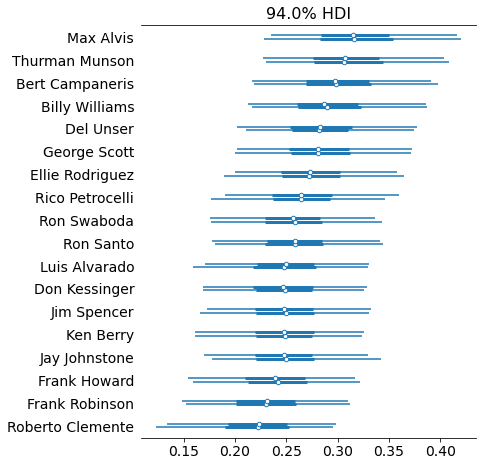

In [8]:
# Plotting the estimates for all 18 players in the dataset:
player_names = data.apply(lambda x: x.FirstName + " " + x.LastName, axis=1)

ax = az.plot_forest(trace, var_names=["thetas"])
ax[0].set_yticklabels(player_names.tolist());

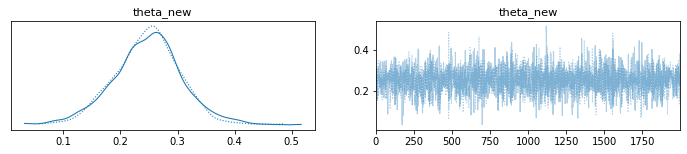

In [9]:
# Now let's estimate for our 4-times player
az.plot_trace(trace, var_names=["theta_new"]);

# Conclusions
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-danger">
<font color=black>

- Notice that, despite the fact our additional player did not get any hits, the estimate of his average is not zero – zero is not even a highly-probably value. 

- This is because we are assuming that the player is drawn from a population of players with a distribution specified by our estimated hyperparemeters. 
    
- However, the estimated mean for this player is toward the low end of the means for the players in our dataset, indicating that the 4 at-bats contributed some information toward the estimate.

</font>
</div>

# References
<hr style = "border:2px solid black" ></hr>

<div class="alert alert-warning">
<font color=black>

- https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/hierarchical_partial_pooling.html
- [Efron and Morris baseball dataset](http://www.swarthmore.edu/NatSci/peverso1/Sports%20Data/JamesSteinData/Efron-Morris%20Baseball/EfronMorrisBB.txt)

</font>
</div>